In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import librosa.display
from tqdm import tqdm
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
# Root directory path
train_root_directory = '/Users/jaeyoung/creamo/ClapNet/data/174.자연 및 인공적 발생 非언어적 소리 데이터/01.데이터/1.Training/원천데이터/TS_3.사람'

test_root_directory = '/Users/jaeyoung/creamo/ClapNet/data/174.자연 및 인공적 발생 非언어적 소리 데이터/01.데이터/2.Validation/원천데이터/VS_3.사람'

# Sound data and labels to process
sound_labels = {
    '1.생리현상/1.기침': 'non_clap',
    '1.생리현상/4.재채기': 'non_clap',
    '2.신체를 이용한 인위적 소리/1.박수': 'clap',
    '3.감정/1.웃음': 'non_clap',
    '3.감정/2.울음': 'non_clap',
    '3.감정/3.비명': 'non_clap',
}

# Window size and other settings
window_duration = 0.6  # seconds
hop_length = 512  # hop length
window_size = None
minimum_distance = None
sr = None  # sampling rate

# Initialize lists for storing data
X_Train = []
Y_Train = []
X_Test = []
Y_Test = []

def process_audio_files(directory, label, is_test=False):
    global window_size, sr, minimum_distance

    file_paths = []
    for root, _, files in os.walk(directory):  # Walk through directory to gather all mp3 files e.g variable files is a list contain all the mp3 format file as an element. All mp3 file under 1.기침 file.
        for file in files:
            if file.endswith('.mp3'):  # Check if file is an mp3
                file_paths.append(os.path.join(root, file))
                # e.g element in file_paths list would be '/Users/jaeyoung/creamo/ClapNet/data/174.자연 및 인공적 발생 非언어적 소리 데이터/01.데이터/1.Training/원천데이터/TS_3.사람/1.생리현상/1.기침/S-211011_H_101_C_025_0001.mp3'

    for file_path in tqdm(file_paths, desc=f'Processing {label} files'):  # Process each file with a progress bar
        y, sr = librosa.load(file_path, sr=None)  # Load audio file. y contains time series data and sr is sampling rate.
        
        # print(y) float between -1.0 to 1.0.
        # print(type(y)) np.darray.
        # print(y.shape) value varis depends on audio length
        # print(sr) 44100 means  keep original audio file's sampling rate.

        start_time = 8  # Start processing from 8 seconds as all the files contain introduction for 8 seconds.
        start_sample = int(start_time * sr)  # Convert start time into audio sample index. e.g 44100 * 8 = 352800. Meaning 352800 sample in audio file is 8 seconds after starting point.
        y_trimmed = y[start_sample:]  # Trim the audio to start from 8 seconds. Again y is holding time series data of audio file. Float between -1.0 to 1.0.
        y_trimmed_db = librosa.amplitude_to_db(np.abs(y_trimmed), ref=np.max)  # Convert amplitude to decibels
        # Dynamic range compression: It can effectively represent even small changes.
        # Similar to human auditory perception: The human ear perceives sound in a manner close to a logarithmic scale.
        # Facilitates signal processing: Many audio processing algorithms operate more effectively on the dB scale.

        threshold_db = -30  # Threshold for detecting sound above noise. -10dB is approximately 31.6% of the maximum amplitude.
        indices = np.where(y_trimmed_db > threshold_db)[0]  # Find indices where sound is above threshold
        
        if window_size is None:
            window_size = int(window_duration * sr)  # Calculate window size in samples e.g our window_duration is 0.6 seconds and sr is 44100. The window_size would be 0.6 * 44100 = 26460.
            minimum_distance = int(0.6 * sr)  # Minimum distance between windows

        last_index = -minimum_distance  # Initialize last index

        for i, idx in enumerate(indices):  # Iterate over detected indices
            if idx - last_index >= minimum_distance:  # Ensure minimum distance between windows
                start_idx = max(0, idx - window_size // 2)  # Calculate start index of window
                end_idx = min(len(y_trimmed), idx + window_size // 2)  # Calculate end index of window
                y_window = y_trimmed[start_idx:end_idx]  # Extract windowed audio segment
                S_window = librosa.feature.melspectrogram(y=y_window, sr=sr, n_mels=128, hop_length=hop_length)  # Create Mel spectrogram
                S_window_dB = librosa.power_to_db(S_window, ref=np.max)  # Convert power spectrogram to decibel units
                S_window_dB_normalized = (S_window_dB - np.min(S_window_dB)) / (np.max(S_window_dB) - np.min(S_window_dB))  # Normalize spectrogram

                # Check the size of the spectrogram and apply padding
                target_width = (window_size // hop_length) + 1  # Calculate target width of spectrogram
                if S_window_dB_normalized.shape[1] >= target_width:  # If spectrogram is smaller than target width
                    if is_test:
                        X_Test.append(S_window_dB_normalized)  # Append normalized spectrogram to test data list
                        Y_Test.append(label)  # Append label to test data list
                    else:
                        X_Train.append(S_window_dB_normalized)  # Append normalized spectrogram to train data list
                        Y_Train.append(label)  # Append label to train data list
                    last_index = idx  # Update last index

# Process all sound data
for subdir, label in tqdm(sound_labels.items(), desc='Processing sound categories'):  # Iterate over sound categories e.g subdir : 1.생리현상/1.기침, label : cough
    train_directory = os.path.join(train_root_directory, subdir)  # Construct directory path e.g /Users/jaeyoung/creamo/ClapNet/data/174.자연 및 인공적 발생 非언어적 소리 데이터/01.데이터/1.Training/원천데이터/TS_3.사람/1.생리현상/1.기침
    process_audio_files(train_directory, label, is_test=False)  # Process training audio files in directory

    test_directory = os.path.join(test_root_directory, subdir)  # Construct directory path e.g /Users/jaeyoung/creamo/ClapNet/data/174.자연 및 인공적 발생 非언어적 소리 데이터/01.데이터/1.Training/원천데이터/TS_3.사람/1.생리현상/1.기침
    process_audio_files(test_directory, label, is_test=True)  # Process test audio files in directory

# Convert lists to numpy arrays
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

X_Test = np.array(X_Test)
Y_Test = np.array(Y_Test)

# Save data
np.save('X_Train.npy', X_Train)
np.save('Y_Train.npy', Y_Train)

np.save('X_Test.npy', X_Test)
np.save('Y_Test.npy', Y_Test)

# Print data shapes
print(f'X_Train shape: {X_Train.shape}')
print(f'Y_Train shape: {Y_Train.shape}')

print(f'X_Test shape: {X_Test.shape}')
print(f'Y_Test shape: {Y_Test.shape}')

Processing sound categories: 100%|██████████| 6/6 [11:02<00:00, 110.33s/it]


X_Train shape: (14147, 128, 52)
Y_Train shape: (14147,)
X_Test shape: (2125, 128, 52)
Y_Test shape: (2125,)


Training data shape: (14147, 128, 52, 1), (14147, 2)
Validation data shape: (1062, 128, 52, 1), (1062, 2)
Test data shape: (1063, 128, 52, 1), (1063, 2)
Epoch 1/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 62s 137ms/step - accuracy: 0.9441 - loss: 5.5203 - val_accuracy: 0.9369 - val_loss: 3.4164 - learning_rate: 1.0000e-04
Epoch 2/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 65s 146ms/step - accuracy: 0.9817 - loss: 2.8906 - val_accuracy: 0.9746 - val_loss: 1.9809 - learning_rate: 1.0000e-04
Epoch 3/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 69s 155ms/step - accuracy: 0.9860 - loss: 1.7548 - val_accuracy: 0.9501 - val_loss: 1.4703 - learning_rate: 1.0000e-04
Epoch 4/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 66s 150ms/step - accuracy: 0.9887 - loss: 1.1415 - val_accuracy: 0.9237 - val_loss: 1.3248 - learning_rate: 1.0000e-04
Epoch 5/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 66s 149ms/step - accuracy: 0.9914 - loss: 0.7964 - val_accuracy: 0.9708 - val_loss: 0.6716 - learning_rate: 1.0000e-04
Epoch 6/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 67s 152ms/st

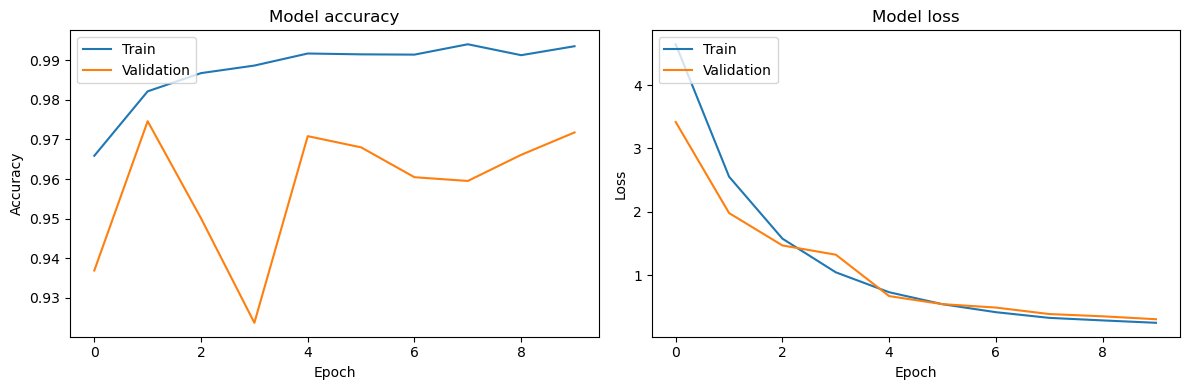

In [3]:
# Load the training data
independent = np.load('X_Train.npy')
independent = independent.reshape(independent.shape[0], independent.shape[1], independent.shape[2], 1)
dependent = np.load('Y_Train.npy')
dependent = pd.get_dummies(dependent).astype(int)


# Load the test data
independent_test = np.load('X_Test.npy')
independent_test = independent_test.reshape(independent_test.shape[0], independent_test.shape[1], independent_test.shape[2], 1)
dependent_test = np.load('Y_Test.npy')

# Split the test data into validation and test sets
independent_val, independent_test, dependent_val, dependent_test = train_test_split(
    independent_test, dependent_test, test_size=0.5, random_state=42)

# One-hot encode the validation and test labels
dependent_val = pd.get_dummies(dependent_val).astype(int)
dependent_test = pd.get_dummies(dependent_test).astype(int)

# Print shapes to verify
print(f'Training data shape: {independent.shape}, {dependent.shape}')
print(f'Validation data shape: {independent_val.shape}, {dependent_val.shape}')
print(f'Test data shape: {independent_test.shape}, {dependent_test.shape}')

# Define the model
X = tf.keras.layers.Input(shape=[128, 52, 1])
H = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(X)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(H)
H = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(H)
H = tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(H)
H = tf.keras.layers.Flatten()(H)
H = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(H)
H = tf.keras.layers.Dropout(0.5)(H)
Y = tf.keras.layers.Dense(len(dependent.columns), activation='softmax')(H)

model = tf.keras.models.Model(X, Y)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(independent, dependent, epochs=10, validation_data=(independent_val, dependent_val), 
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(independent_test, dependent_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [4]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(independent_test, dependent_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9557 - loss: 0.3676
Test Loss: 0.3551025986671448
Test Accuracy: 0.9623706340789795


In [18]:
# Make predictions
pred = model.predict(independent_test)
predicted_labels = np.argmax(pred, axis=1)
true_labels = np.argmax(dependent_test.values, axis=1)

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=dependent_test.columns)
print(report)

# Generate a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Overall Accuracy: {overall_accuracy}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
              precision    recall  f1-score   support

        clap       1.00      0.85      0.92       271
    non_clap       0.95      1.00      0.98       792

    accuracy                           0.96      1063
   macro avg       0.98      0.93      0.95      1063
weighted avg       0.96      0.96      0.96      1063

[[231  40]
 [  0 792]]
Overall Accuracy: 0.9623706491063029


In [24]:
model.save('./my_model.keras')

In [25]:
import os
import numpy as np
import librosa
from tqdm import tqdm

# Window size and other settings
window_duration = 0.6  # seconds
hop_length = 512  # hop length
window_size = None
minimum_distance = None
sr = None  # sampling rate
timstamps = []
def process_single_audio_file(file_path):
    global window_size, sr, minimum_distance

    y, sr = librosa.load(file_path, sr=None)  # Load audio file
    y_db = librosa.amplitude_to_db(np.abs(y), ref=np.max)  # Convert amplitude to decibels

    threshold_db = -30  # Threshold for detecting sound above noise.
    indices = np.where(y_db > threshold_db)[0]  # Find indices where sound is above threshold
    
    if window_size is None:
        window_size = int(window_duration * sr)  # Calculate window size in samples
        minimum_distance = int(0.6 * sr)  # Minimum distance between windows

    last_index = -minimum_distance  # Initialize last index

    X_Data = []

    for idx in indices:  # Iterate over detected indices
        if idx - last_index >= minimum_distance:  # Ensure minimum distance between windows
            start_idx = max(0, idx - window_size // 2)  # Calculate start index of window
            end_idx = min(len(y), idx + window_size // 2)  # Calculate end index of window
            y_window = y[start_idx:end_idx]  # Extract windowed audio segment
            S_window = librosa.feature.melspectrogram(y=y_window, sr=sr, n_mels=128, hop_length=hop_length)  # Create Mel spectrogram
            S_window_dB = librosa.power_to_db(S_window, ref=np.max)  # Convert power spectrogram to decibel units
            S_window_dB_normalized = (S_window_dB - np.min(S_window_dB)) / (np.max(S_window_dB) - np.min(S_window_dB))  # Normalize spectrogram

            # Check the size of the spectrogram and apply padding
            target_width = (window_size // hop_length) + 1  # Calculate target width of spectrogram
            if S_window_dB_normalized.shape[1] >= target_width:  # If spectrogram is smaller than target width
                X_Data.append(S_window_dB_normalized)  # Append normalized spectrogram to data list
                last_index = idx  # Update last index
                timstamps.append(idx/sr)
    return np.array(X_Data), timstamps

In [26]:
# Example usage:
file_path = 'audio.mp3'
X_Data ,timestamps = process_single_audio_file(file_path)

# Print data shape
print(f'X_Data shape: {X_Data.shape}')
print("Clap timestamps: ", timestamps)

# Save data if needed
np.save('X_Data.npy', X_Data)

X_Data shape: (11, 128, 52)
Clap timestamps:  [0.7865759637188209, 1.624421768707483, 2.4899546485260773, 3.3190929705215417, 4.1545124716553286, 4.994807256235828, 5.960589569160998, 6.816462585034014, 7.6308843537414965, 8.447936507936507, 9.274671201814058]


In [27]:
import numpy as np
from tensorflow import keras

# Load the data and model
X_Data = np.load('X_Data.npy')
model = keras.models.load_model('my_model.keras')

# Print the shape of X_Data
print(X_Data.shape)

# Reshape X_Data to 4D if necessary (assuming it's a 3D array)
X_Data = X_Data.reshape(X_Data.shape[0], X_Data.shape[1], X_Data.shape[2], 1)

# Perform predictions
predictions = model.predict(X_Data)

# Predict classes for each window
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)
# Determine the final prediction based on the most common predicted class
final_prediction = max(set(predicted_classes), key=list(predicted_classes).count)
label_map = {0: 'clap', 1: 'non_clap'}  # Update this according to your label mapping used during model training
final_label = label_map[final_prediction]

print(f'The predicted label for the audio file is: {final_label}')

# Assuming timestamps is a list of timestamps corresponding to X_Data
if final_label == 'clap':
    # Create a new list excluding timestamps where the predicted class is 'non_clap'
    timestamps = [timestamp for idx, timestamp in enumerate(timestamps) if predicted_classes[idx] != 1]
print("Num of clap", len(timestamps))
print(timestamps)


(11, 128, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
[0 0 0 0 0 0 0 0 0 0 0]
The predicted label for the audio file is: clap
Num of clap 11
[0.7865759637188209, 1.624421768707483, 2.4899546485260773, 3.3190929705215417, 4.1545124716553286, 4.994807256235828, 5.960589569160998, 6.816462585034014, 7.6308843537414965, 8.447936507936507, 9.274671201814058]


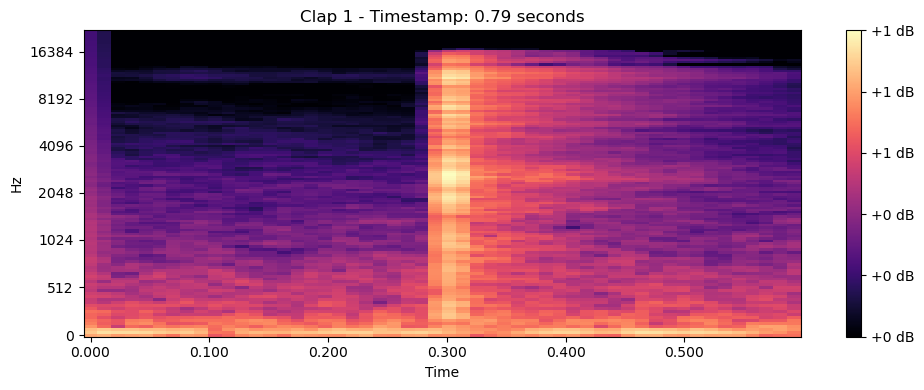

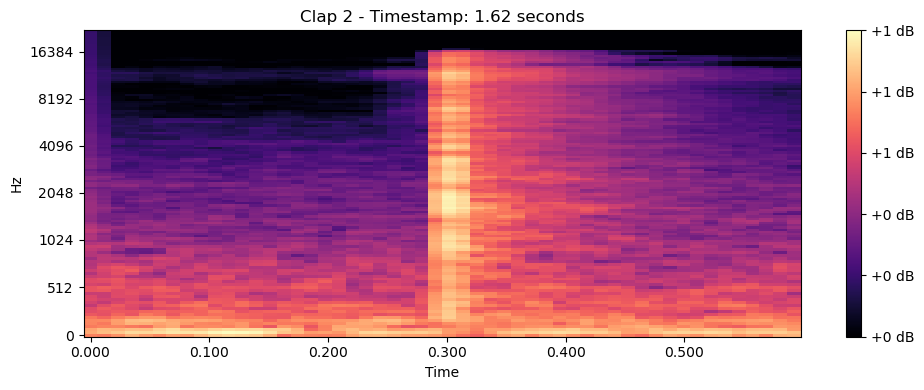

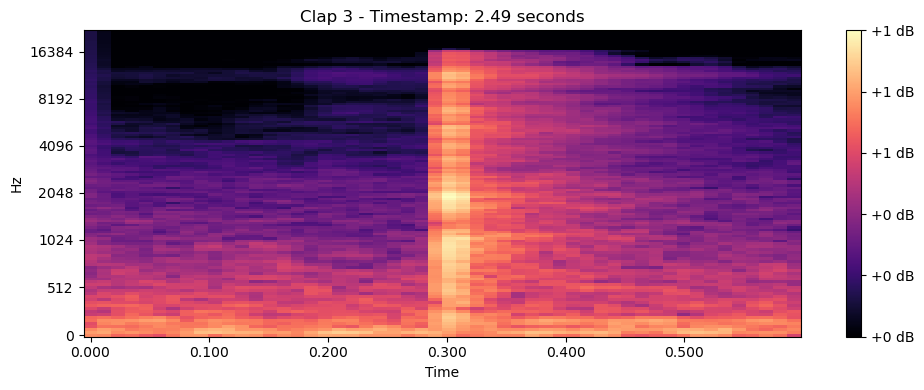

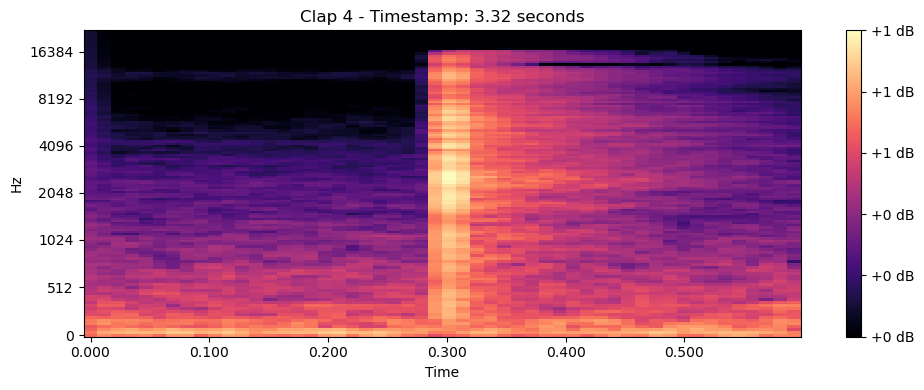

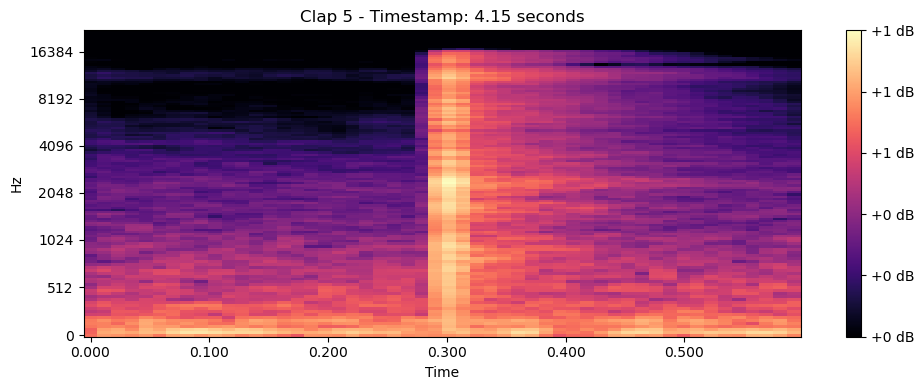

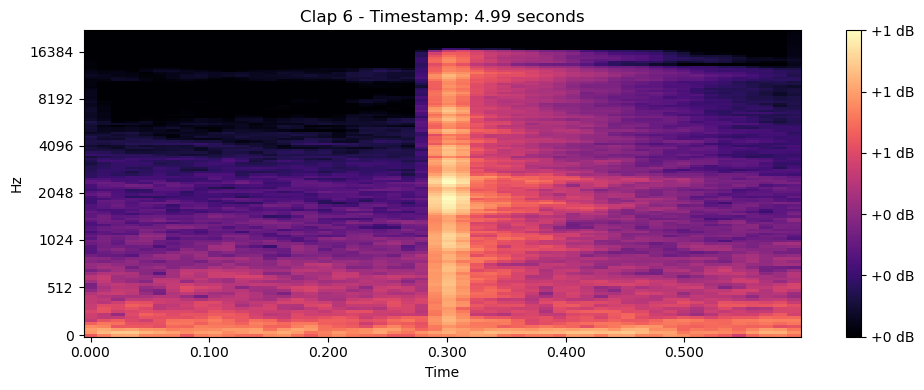

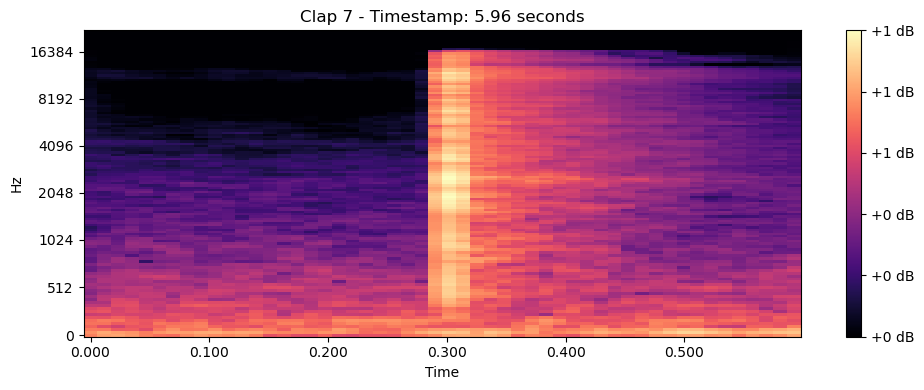

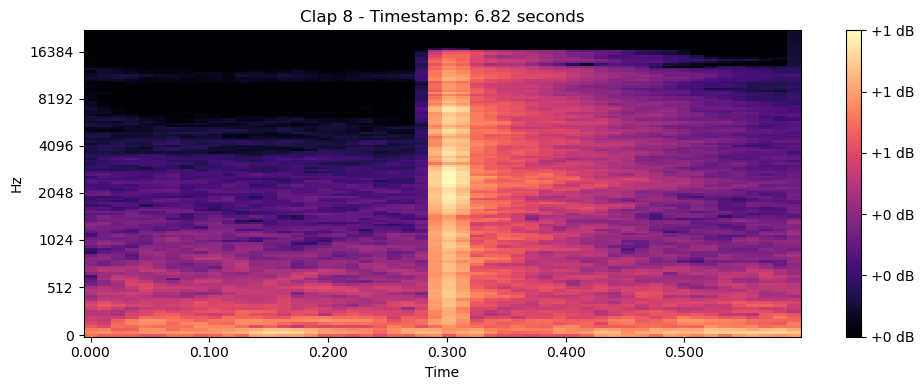

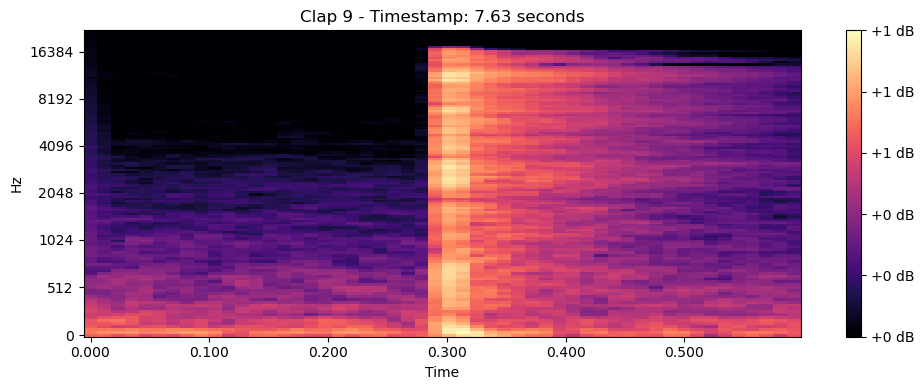

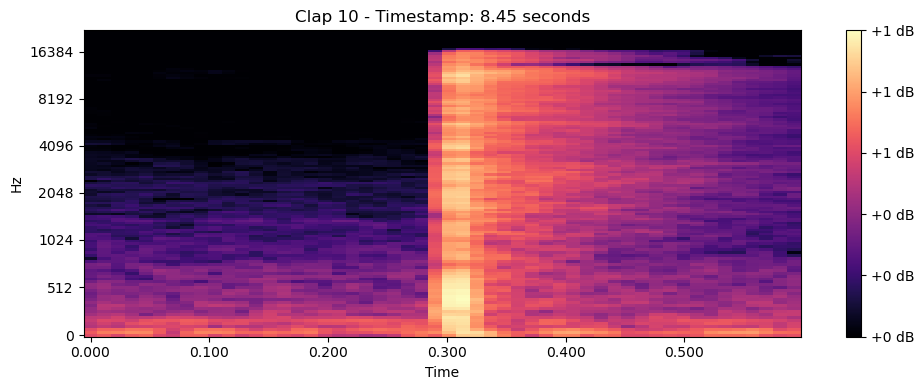

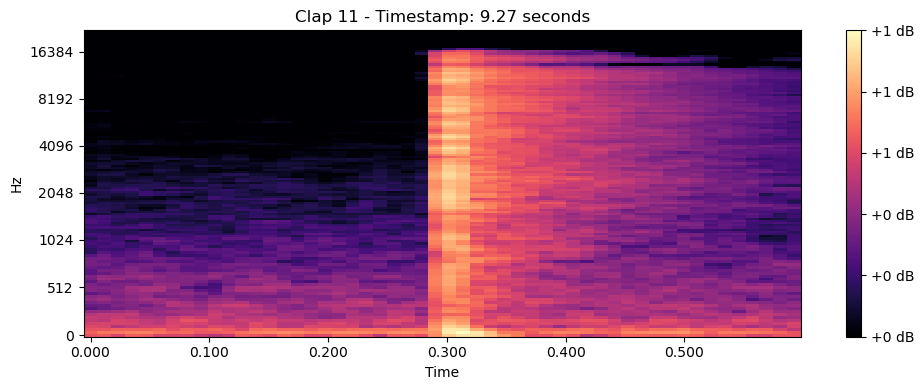

In [28]:
# Function to plot Mel-spectrograms for 'clap' class
def plot_clap_spectrograms(X_Data, predicted_classes):
    clap_indices = [idx for idx, cls in enumerate(predicted_classes) if cls == 0]
    num_claps = len(clap_indices)
    
    for i, idx in enumerate(clap_indices):
        plt.figure(figsize=(10, 4))
        plt.title(f'Clap {i+1} - Timestamp: {timestamps[idx]:.2f} seconds')
        librosa.display.specshow(X_Data[idx, :, :, 0], sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

# Plot the Mel-spectrograms for 'clap' class
plot_clap_spectrograms(X_Data, predicted_classes)